In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import tqdm
%matplotlib inline

In [14]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [15]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [16]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [17]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

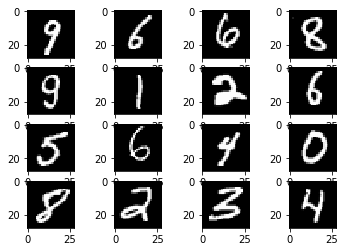

In [18]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [19]:
# Подготовка датасета
# Подготовим файлы датасета

with open('./data_train.pickle', 'rb') as f:
    train = pickle.load(f)
with open('./data_test_no_labels.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

# Отнормируем данные

x = train['data']
y = train['target']
x = x.astype('float')

xm = np.mean(x, axis = 0)
xs = np.std(x, axis = 0)
x = (x - xm) / (xs + 0.00001)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size  = 0.25)

In [20]:
# Определение слоев сети
# class Dense:
# Реализуем по аналогии с лекцией

class Dense:
    
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.003): ###
        self.dW = np.outer(dz, self.x)
        self.db = dz
        self.dx = np.matmul(dz, self.W) 
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        return self.dx

In [21]:
# Определение слоев сети
# class Max:
# Реализуем по аналогии с лекцией

class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.01): ###
        dz[self.x < 0] = 0
        return dz

In [22]:
# Определение слоев сети
# class  SoftMax:
# Реализуем по аналогии с лекцией

class SoftMax:
    
    def forward(self, x):
        self.x = x
        exp = np.exp(x)
        return exp / np.sum(exp)

    def backward(self, dz, lr = 0.002): ###
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [23]:
# Определим loss-функцию CrossEntropy
# class CrossEntropy:

class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr = 0.01): ###
        return -dz * self.y_true / self.y_hat

In [24]:
# Опеределение самой сети
# class MnistNet:

class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d_1 = Dense(x_train.shape[1], 100, rlambda) ###
        self.m = Max()
        self.d_2 = Dense(100, 10, rlambda) ###
        self.s = SoftMax()
    
    def forward(self, x):
        net = self.d_1.forward(x)
        net = self.m.forward(net)
        net = self.d_2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d_2.backward(dz, lr)
        dz = self.m.backward(dz, lr)
        dz = self.d_1.backward(dz, lr)
        return dz

In [36]:
# Здесь процедура обучения
# net = MnistNet()
# loss = CrossEntropy()

net = MnistNet(0.0001)
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []
acc_train = []
acc_test = []
encdr = OneHotEncoder()
for iter in tqdm.tqdm_notebook(range(4)):
    L_acc = 0.
    sh = list(range(x_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(x_train.shape[0]):
        x = x_train[sh[i]]
        y = encdr.transform(y_train[sh[i]])
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(x_val.shape[0]):
        x = x_val[i]
        y = encdr.transform(y_val[i])
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
    L_e_acc /= y_val.shape[0]
    L_test.append(L_e_acc)
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))
    acc_train.append(compute_acc(x_train, y_train, net)) # Добавлено
    acc_test.append(compute_acc(x_val, y_val, net)) # Добавлено


0 iter loss. Train : 0.35388192290184756 . Test : 0.23807328885265913
1 iter loss. Train : 0.1682018398253158 . Test : 0.20024787403615824
2 iter loss. Train : 0.12358999311078621 . Test : 0.1773670027542876
3 iter loss. Train : 0.09682783705033439 . Test : 0.1684642812097843



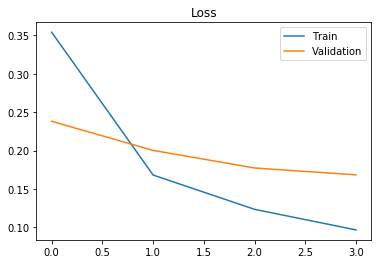

In [37]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
# plot(L_train, label="train")
plt.title('Loss')
plt.plot(L_train, label = 'Train')
plt.plot(L_test, label = 'Validation')
plt.legend();

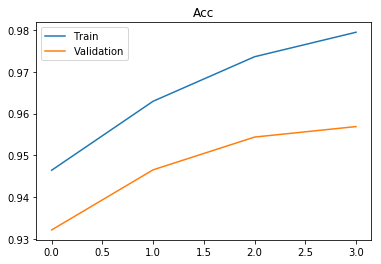

In [38]:
# Добавил график для Accuracy
plt.title('Acc')
plt.plot(acc_train, label='Train')
plt.plot(acc_test, label='Validation')
plt.legend();

In [39]:
# формируем сабмишшен и заливаем его на kaggle
xx = test_no_lables['data']


xx = xx.astype('float')
xx = (xx - xm) / (xs + 0.00001)


make_submission(xx, net)

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


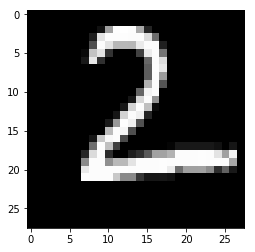

In [48]:
I = train_data['data'][160]
I = I.reshape((28, 28))
plt.imshow(I, cmap = 'gray')

In [45]:
y_h = net.forward(train_data['data'][160])
y = np.argmax(y_h)
y

/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/Users/bulat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


2

In [4]:
import numpy as np
x = np.ones(2)
np.sum(x)

2.0